In [53]:
# Make a histogram of the difference between each timestamp in the gaze data

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from utils import (
    TIMESTAMP_IDENT,
    X_PIXELS,
    Y_PIXELS,
    Events,
)
import json


EYE_TRACKER_FOLDER = "eye_tracker_data/"
GAZE_DATA = []
GAZE_DATA_BOOK = []
GAZE_DATA_PAGE = []

# get all participants from the database
participant_ids = [
    event.participant_id for event in Events.select(Events.participant_id).distinct()
]
# Remove 998 and 999
subquery = Events.select().where(Events.participant_id.in_(participant_ids))

DIFFERENCES_TOTAL = []

# get all the gaze data from the database
for participant in participant_ids:
    # if participant id starts with 9, skip
    if f'{participant}'.startswith("9"):
        continue
    # Get all the open_book events for the participant
    books = subquery.where(
        Events.participant_id == participant, Events.event == "OPEN_BOOK"
    )
    for book in books:
        START_TIME_BOOK = book.time
        participants = json.load(open("participants.json", "r"))
        LOW_RES = participants[f'{participant}']["low_resolution"]

        if not LOW_RES:
            START_TIME_BOOK /= 1000

        formatted_time = datetime.fromtimestamp(START_TIME_BOOK).strftime(
            "%Y-%m-%d_%H-%M-%S"
        )
        GAZE_FILE = f"{EYE_TRACKER_FOLDER}[{participant}]-{formatted_time}.json"
        f = open(GAZE_FILE, "r")
        GAZE_DATA_BOOK = json.load(f)
        f.close()
        df = pd.DataFrame(GAZE_DATA_BOOK['data'])
        timestamps = df[TIMESTAMP_IDENT] / 1000
        differences = np.diff(timestamps)

        DIFFERENCES_TOTAL.extend(differences)


4044
1436553
96478.39100048074
16002022.330036428


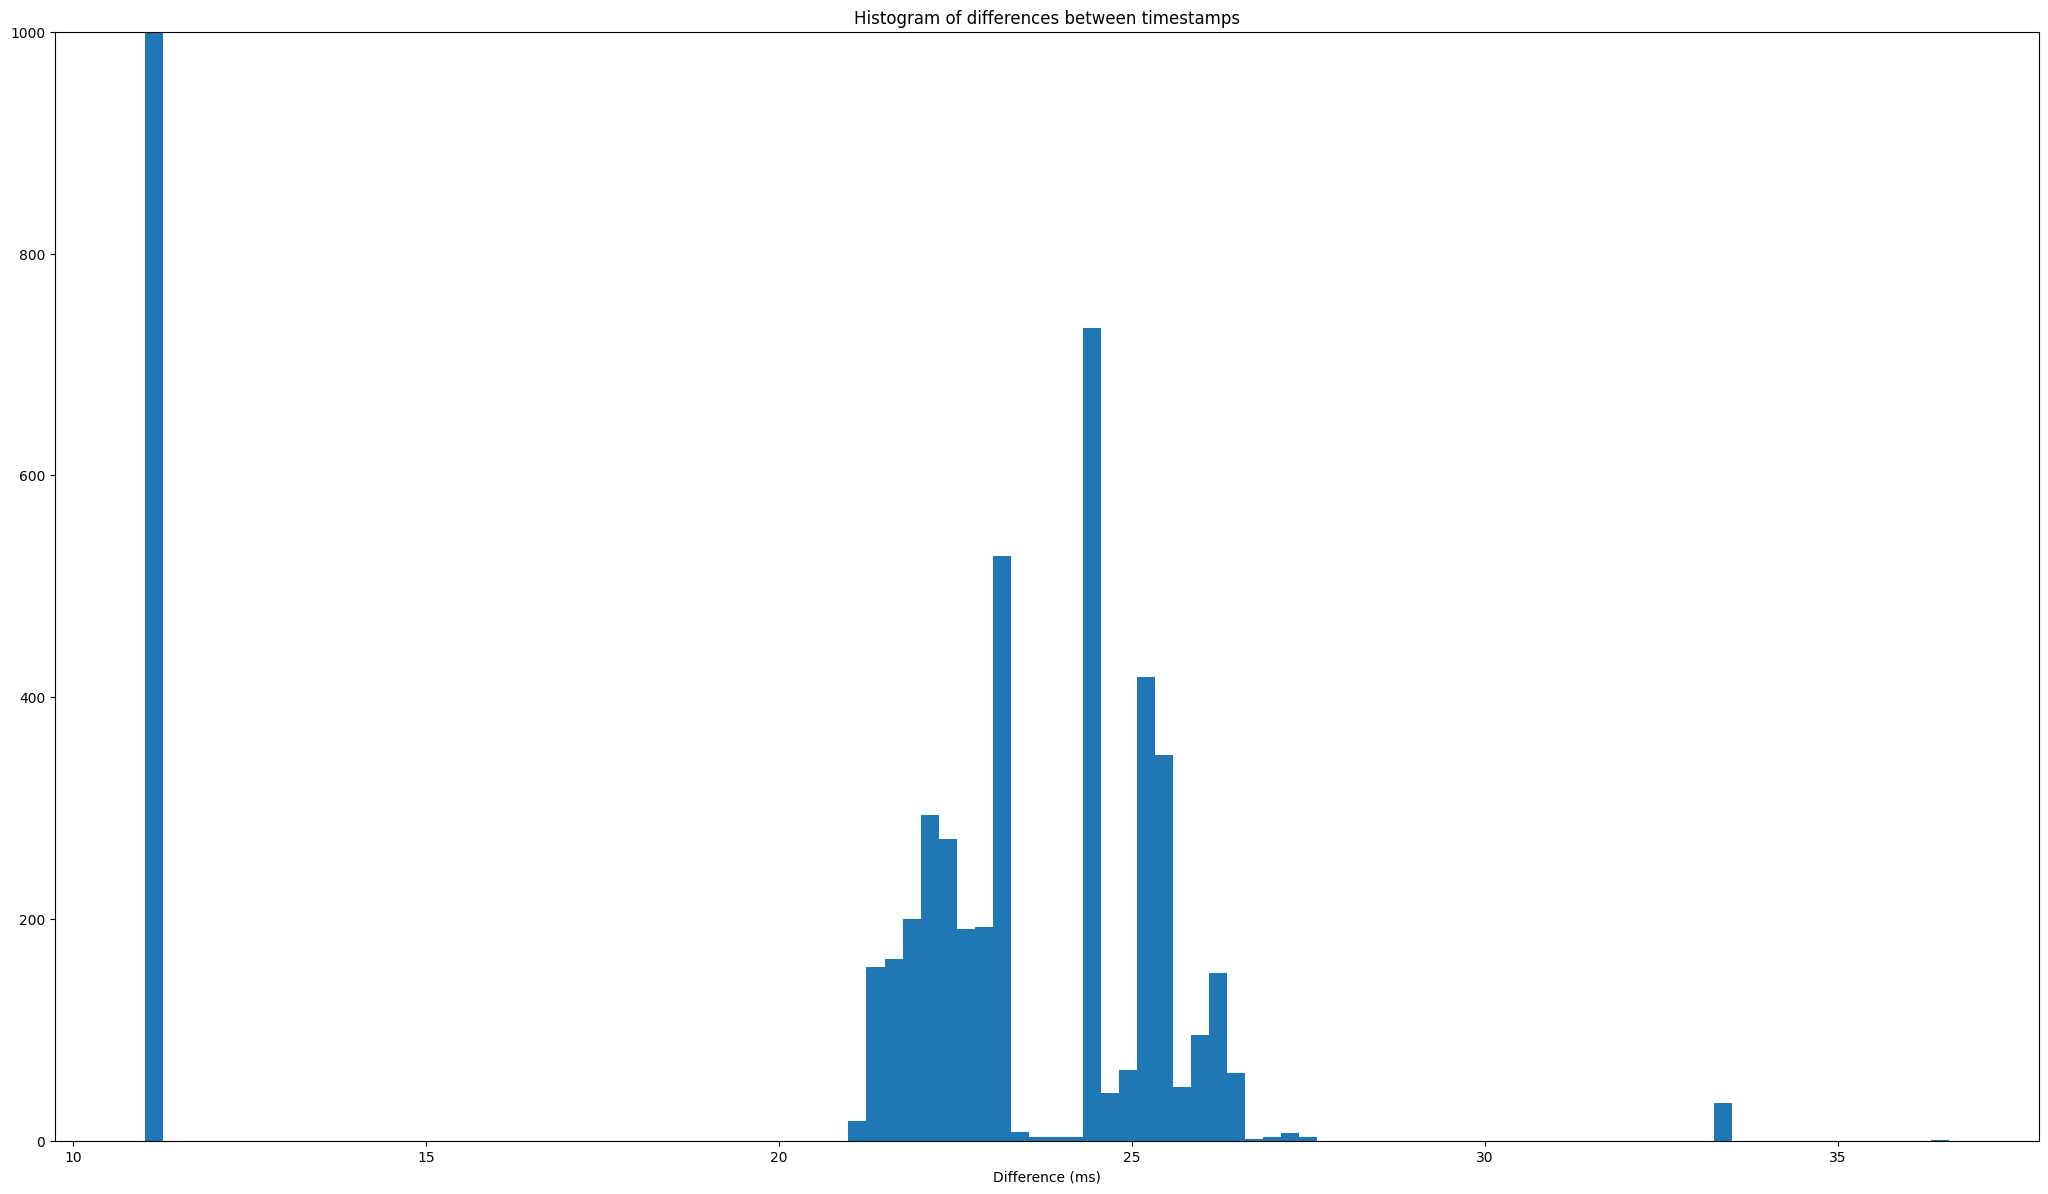

In [54]:
fig, ax = plt.subplots(figsize=(X_PIXELS / 100, Y_PIXELS / 100))

# Add the differences to the histogram
ax.set_title("Histogram of differences between timestamps")
ax.set_xlabel("Difference (ms)")
ax.set_ylim(0, 1000)

#Label each bin
n, bins, patches = ax.hist(DIFFERENCES_TOTAL, bins=100)

# # Add text to each bin, that shows the value that the bin contains
# for i in range(len(bins) - 1):
#     if n[i] > 0 and n[i] < 1000:
#         ax.text(
#             (bins[i] + bins[i + 1]) / 2,
#             n[i],
#             patches[i].xy[0],
#             horizontalalignment="center",
#             verticalalignment="bottom",
#        )


# Filter out the differences that are less than 0.2 seconds
filtered = [x for x in DIFFERENCES_TOTAL if x > 15]
print(len(filtered))
print(len(DIFFERENCES_TOTAL))
print(sum(filtered))
print(sum(DIFFERENCES_TOTAL))

# Overview of data quality per participant

In [55]:

# get all participants from the database
participant_ids = [
    event.participant_id for event in Events.select(Events.participant_id).distinct()
]
# Remove 998 and 999
subquery = Events.select().where(Events.participant_id.in_(participant_ids))

# particiant | expected_packets | actual_packets | percentage | time missing 
#make dataframe based on above

overall_data_integrity = {}
gaze_point_validity = {}

# get all the gaze data from the database
for participant in participant_ids:
    # if participant id starts with 9, skip
    if f'{participant}'.startswith("9"):
        continue
    # Get all the open_book events for the participant
    books = subquery.where(
        Events.participant_id == participant, Events.event == "OPEN_BOOK"
    )

    for book in books:
        if book.new_value != "Under the Tuscan Sun - ":
            continue

        if participant == 5 and participant in overall_data_integrity:
            continue
        elif participant == 6 and participant not in overall_data_integrity:
            continue

        START_TIME_BOOK = book.time
        participants = json.load(open("participants.json", "r"))
        LOW_RES = participants[f'{participant}']["low_resolution"]

        if not LOW_RES:
            START_TIME_BOOK /= 1000

        formatted_time = datetime.fromtimestamp(START_TIME_BOOK).strftime(
            "%Y-%m-%d_%H-%M-%S"
        )
        GAZE_FILE = f"{EYE_TRACKER_FOLDER}[{participant}]-{formatted_time}.json"
        f = open(GAZE_FILE, "r")
        GAZE_DATA_BOOK = json.load(f)
        f.close()

        first_packet_timestamp = GAZE_DATA_BOOK['data'][0][TIMESTAMP_IDENT] / 1000
        last_packet_timestamp = GAZE_DATA_BOOK['data'][-1][TIMESTAMP_IDENT] / 1000
        num_expected_packets = int(last_packet_timestamp - first_packet_timestamp) / 11 
        num_actual_packets = len(GAZE_DATA_BOOK['data'])
        percentage = (num_actual_packets / num_expected_packets) * 100
        time_missing = (num_expected_packets - num_actual_packets) * 0.011
        length_of_experiment = (last_packet_timestamp - first_packet_timestamp) / 1_000
        left_gaze_validity = len([x['left_gaze_point_validity'] for x in GAZE_DATA_BOOK['data'] if x['left_gaze_point_validity'] == 1]) / len(GAZE_DATA_BOOK['data']) * 100
        right_gaze_validity = len([x['right_gaze_point_validity'] for x in GAZE_DATA_BOOK['data'] if x['right_gaze_point_validity'] == 1]) / len(GAZE_DATA_BOOK['data']) * 100

        overall_data_integrity[participant] = [num_expected_packets, length_of_experiment, time_missing, percentage]
        gaze_point_validity[participant] = [num_expected_packets, length_of_experiment, left_gaze_validity, right_gaze_validity]



In [59]:
df = pd.DataFrame(overall_data_integrity, index=["Number of packets expected",  "Length of experiment (s)", "Amount of time missing (s)","Percentage recorded"]).T
df.sort_index(inplace=True)

# round number packets to int
df["Number of packets expected"] = df["Number of packets expected"].astype(int)

# 2 signficant figures for the rest
df["Percentage recorded"] = df["Percentage recorded"].round(2)
df["Length of experiment (s)"] = df["Length of experiment (s)"].round(2)
df["Amount of time missing (s)"] = df["Amount of time missing (s)"].round(2)
    
df

,Number of packets expected,Length of experiment (s),Amount of time missing (s),Percentage recorded
1,15102,166.13,1.53,99.08
2,16444,180.89,1.67,99.08
4,13135,144.49,1.33,99.08
5,18440,202.85,1.87,99.08
7,19743,217.18,2.01,99.08
8,19451,213.97,1.98,99.08
10,17750,195.25,1.80,99.08
11,21241,233.66,2.16,99.07
12,20017,220.19,2.30,98.95
13,17151,188.67,2.30,98.78


In [72]:
df = pd.DataFrame(gaze_point_validity, index=["Number of packets expected",  "Length of experiment (s)",  "Left gaze point validity (%)", "Right gaze point validity (%)"]).T
df.sort_index(inplace=True)

# round number packets to int
df["Number of packets expected"] = df["Number of packets expected"].astype(int)

# 2 signficant figures for the rest
df["Length of experiment (s)"] = df["Length of experiment (s)"].round(2)
df["Left gaze point validity (%)"] = df["Left gaze point validity (%)"].round(2)
df["Right gaze point validity (%)"] = df["Right gaze point validity (%)"].round(2)
    
df.to_latex("missing_data_2.tex")

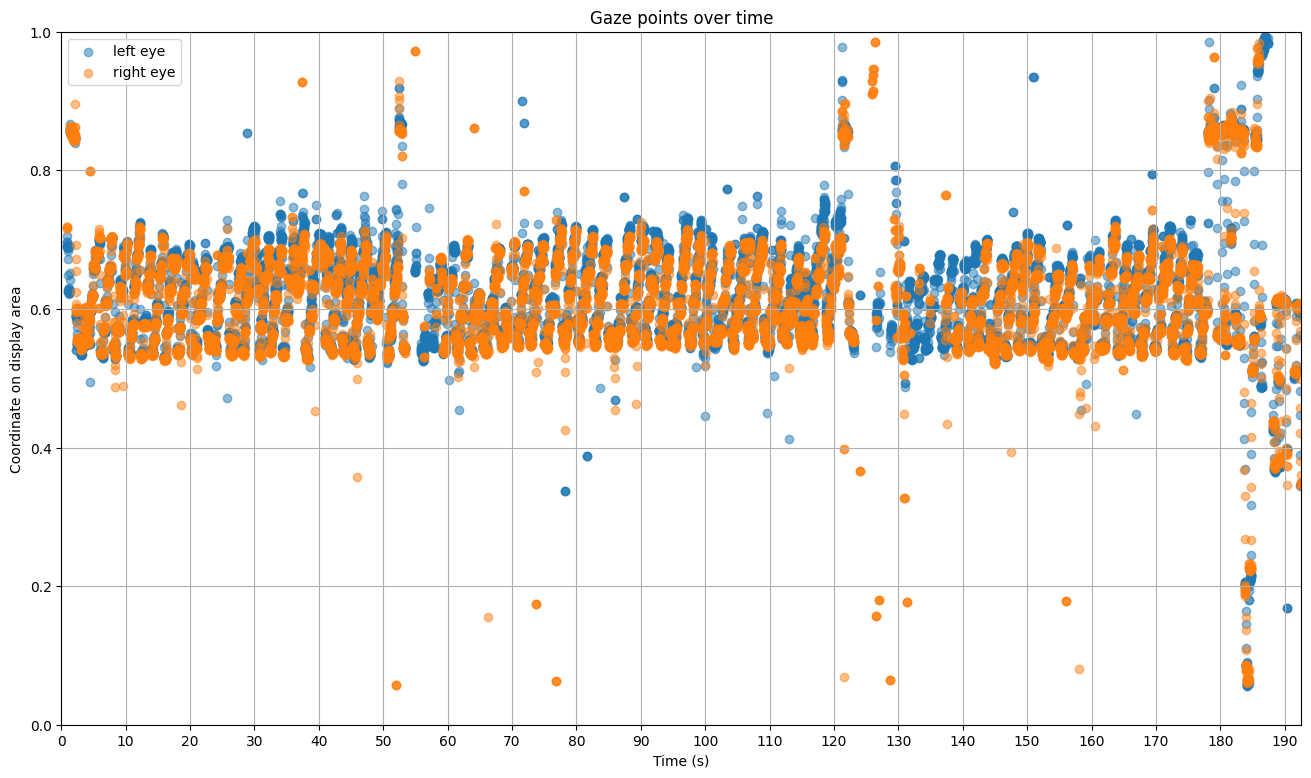

left 88.76203655653578
right 83.73983739837398


In [70]:
# FILENAME = "[12]-2023-12-02_13-27-33.json"
FILENAME = "[12]-2023-12-02_13-31-55.json"
# FILENAME = "[12]-2023-12-02_13-35-38.json"
f = open(EYE_TRACKER_FOLDER + FILENAME, "r")
GAZE_DATA_BOOK = json.load(f)
f.close()

# normalized timestamps for x axis
timestamps = GAZE_DATA_BOOK['data']
timestamps = [x[TIMESTAMP_IDENT] for x in timestamps]
timestamps = [x - timestamps[0] for x in timestamps]
timestamps = [x / 1000000 for x in timestamps]

# x and y coordinates for the gaze points
x = [x['right_gaze_point_on_display_area'][0] for x in GAZE_DATA_BOOK['data']]
x2 = [x['left_gaze_point_on_display_area'][0] for x in GAZE_DATA_BOOK['data']]
y = [x['right_gaze_point_on_display_area'][1] for x in GAZE_DATA_BOOK['data']]
y2 = [x['left_gaze_point_on_display_area'][1] for x in GAZE_DATA_BOOK['data']]

# plot the gaze points
fig, ax = plt.subplots(figsize=(16, 9))
ax.scatter(timestamps, x2, label="left eye", alpha=0.5)
ax.scatter(timestamps, x, label="right eye", alpha=0.5)
# more x-ticks 
ax.set_xticks(np.arange(0, max(timestamps), 10))
# add grid lines for x-axis
ax.grid(True, which='both')
# ax.scatter(timestamps, y, label="y")
# make x axis start at 0
ax.set_xlim(0, max(timestamps))
ax.set_ylim(0, 1)
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("Coordinate on display area")
ax.set_title("Gaze points over time")
plt.show()

first_packet_timestamp = GAZE_DATA_BOOK['data'][0][TIMESTAMP_IDENT] / 1000
last_packet_timestamp = GAZE_DATA_BOOK['data'][-1][TIMESTAMP_IDENT] / 1000
num_expected_packets = int(last_packet_timestamp - first_packet_timestamp) / 11 
num_actual_packets = len(GAZE_DATA_BOOK['data'])
percentage = (num_actual_packets / num_expected_packets) * 100
time_missing = (num_expected_packets - num_actual_packets) * 0.011
length_of_experiment = (last_packet_timestamp - first_packet_timestamp) / 1_000
left_gaze_validity = len([x['left_gaze_point_validity'] for x in GAZE_DATA_BOOK['data'] if x['left_gaze_point_validity'] == 1]) / len(GAZE_DATA_BOOK['data']) * 100
right_gaze_validity = len([x['right_gaze_point_validity'] for x in GAZE_DATA_BOOK['data'] if x['right_gaze_point_validity'] == 1]) / len(GAZE_DATA_BOOK['data']) * 100

# print(num_expected_packets)
# print(num_actual_packets)
# print(percentage)
# print(time_missing)
# print(length_of_experiment)
print("left", left_gaze_validity)
print("right", right_gaze_validity)


